# The NetSecure NIDS - Example answers
The startup company NetSecure has been observing the recent hacks on the news. Because they are working on a new product, and they want to protect their intellectual property, they have decided to improve their network security.
	
To this end, they want to deploy a Network Intrusion Detection System (NIDS) that analyses all the traffic passing between their internal network and the internet. Unfortunately, all security solutions provided by security companies are too expensive for NetSecure. Therefore tin this notebook we are going to attempt to build a NIDS.

## Network setup
NetSecure is a small company with only 3 employees. All of whom have a single desktop machine which they use for their daily work. Furthermore, the company runs a server which provides various webservices to the internet. Figure 1 gives an overview of the network structure of NetSecure. It also shows where the NIDS will be placed.

<img src="images/network.png" width=600>
<div align="center">Figure 1. Overview of the network setup of company NetSecure, including the IP addresses of their machines.</div>

## Available data
In order to train the NIDS that we are creating we are given two datasets of network traffic, both captured at the router as given in Figure 1.
	
 1. `data/benign.csv`, a dataset of benign traffic.
 2. `data/unknown.csv`, a dataset of unknown traffic.

Once we have trained the NIDS, we will test the unknown traffic to determine which parts should be classified as benign and which parts should be classified as malicious.
	
The network traffic that is captured is provided as a .csv file of individual TCP and UDP packets. Each packet has the following features:

| Feature   | Type   | Description                                           |
|-----------|--------|-------------------------------------------------------|
| timestamp | int    | Timestamp at which packet was sent.                   |
| protocol  | string | Indicating whether a packet was sent over UDP or TCP. |
| src       | string | Source IP address of the packet.                      |
| sport     | int    | Source port of the packet.                            |
| dst       | string | Destination IP of the packet.                         |
| dport     | int    | Destination port of the packet.                       |
| size      | int    | Number of bytes in packet that was sent.              |

Furthermore, the dataset of benign traffic also contains labels of the applications that are generating the network traffic.

## Implementation


In [1]:
# Imports numpy and pandas libraries
import numpy  as np
import pandas as pd
# Imports type hints
from typing import Literal, List, Optional, Tuple

# Imports assignment from backend
from ml4sec import Assignment

# Initialises assignment with given files.
assignment = Assignment(
    file_benign  = 'data/benign.csv',
    file_unknown = 'data/unknown.csv',
) 

## 1. Feature selection/extraction
The network packets in the transport layer (i.e. TCP and UDP packets) all belong to a network flow. Such a flow is given by the 5-tuple (*protocol*, *src*, *sport*, *dst*, *dport*). All of the packets within such a flow belong to the same application. We can leverage this knowledge to group packets together and extract statistical features from them as a group.

We should compute some statistical features of each group. These features will give us an advantage in the detection phase of our NIDS. We can compute the following statistical features:

In [4]:
# 0 duration (total duration of a flow in seconds)

# max time between packets
# frequency (p/sec)
# max packet size
# min packet size
# number of bytes (total number of bytes in a flow)

# number of packets
# source port         

We now want to extract these new features for each flow. So we will implement the function `extract()` which has access to the `protocol`, `src`, `sport`, `dst`, `dport` of a flow, as well as the `timestamps`, and `sizes` for each packet within the flow. `extract` returns a list of extracted features. This function is called for each flow.

In [2]:
import sys

def extract(
        protocol  : Literal['UDP', 'TCP'],
        src       : str,
        sport     : int,
        dst       : str,
        dport     : int,
        timestamps: np.ndarray,
        sizes     : np.ndarray,
    ) -> List[float]:
    
    features = list()
    
    earliestTimestamp = sys.float_info.max
    latestTimestamp = 0
    prevTime = 0
    maxTime = 0
    count = 0
    time = 0
    for t in range(timestamps.size):
        # duration 
        if timestamps[t] < earliestTimestamp:
            earliestTimestamp = timestamps[t]
        if timestamps[t] > latestTimestamp:
            latestTimestamp = timestamps[t]
        
        # frequency
        if t == 0:
            prevTime = timestamps[t]
        else:
            prevTime = timestamps[t-1]
        count = count + 1
        tbp = timestamps[t] - prevTime
        time = time + tbp
        if tbp > maxTime:
            maxTime = tbp
    #features.append(time/count)
    # max time between packets
    features.append(maxTime)
    
    
    # duration of a flow
    duration = latestTimestamp - earliestTimestamp
    features.append(duration) 
    
    # number of packets
    numPackets = sizes.size
    features.append(numPackets)
    
    # frequency
    frequency = numPackets/duration
    features.append(frequency)
    
    # max packet size
    maxSize = 0
    minSize = sys.maxsize
    summ = 0
    for s in sizes:
        summ = summ + s
        if s > maxSize:
            maxSize = s
        if s < minSize:
            minSize = s
    features.append(maxSize)
    features.append(minSize)
    
    # number of bytes
    features.append(summ)
    
    
    x = src.split(".")
    features.append(x[3])
    # avrg packet size
    #features.append(summ/numPackets)
    
    # source port
    #features.append(sport)
    
    
    return features
    

# Set extract method
assignment.extract = extract

Now we test our implementation of `extract()` with a given number of flows.

In [169]:
assignment.test_extract(1)

Flow (TCP, 10.0.0.1, 27, 94.173.2.115, 443):
	timestamps        : [1.60754158e+09 1.60754159e+09 1.60754159e+09 1.60754159e+09
 1.60754159e+09 1.60754159e+09 1.60754160e+09 1.60754160e+09
 1.60754160e+09 1.60754160e+09 1.60754160e+09 1.60754161e+09
 1.60754161e+09 1.60754161e+09 1.60754161e+09 1.60754161e+09
 1.60754162e+09 1.60754162e+09 1.60754162e+09 1.60754162e+09
 1.60754162e+09 1.60754163e+09 1.60754163e+09 1.60754163e+09
 1.60754163e+09 1.60754163e+09 1.60754164e+09 1.60754164e+09
 1.60754164e+09 1.60754164e+09 1.60754164e+09 1.60754165e+09
 1.60754165e+09 1.60754165e+09 1.60754165e+09 1.60754165e+09
 1.60754166e+09 1.60754166e+09 1.60754166e+09 1.60754166e+09
 1.60754166e+09 1.60754167e+09 1.60754167e+09 1.60754167e+09
 1.60754167e+09 1.60754167e+09 1.60754168e+09 1.60754168e+09
 1.60754168e+09]
	sizes             : [846 788 765 721 786 766 728 815 867 787 803 753 770 746 693 802 780 749
 778 797 758 723 837 813 732 827 796 776 664 824 782 802 765 850 736 745
 714 833 857 860 7

Now that we extracted the features, we represent them in a feature matrix. Each row in this matrix represents a flow and each column represents a feature.

In [170]:
# Shows feature matrix
assignment.show_matrix()

,0,1,2,3,4,5,6,7
0,2.183502,96.840905,49.0,0.505985,867.0,664.0,38097.0,1.0
1,2.247272,95.054401,48.0,0.504974,906.0,702.0,37942.0,1.0
2,1.260010,41.285953,43.0,1.041516,799.0,483.0,26551.0,1.0
3,2.232194,82.355110,42.0,0.509987,1187.0,1129.0,48671.0,1.0
4,2.276765,84.552949,43.0,0.508557,1194.0,1134.0,50085.0,1.0
...,...,...,...,...,...,...,...,...
12584,1.196490,36.179766,37.0,1.022671,1151.0,838.0,36875.0,2.0
12585,1.211509,36.525565,37.0,1.012989,1156.0,801.0,36769.0,2.0
12586,1.258667,38.898447,40.0,1.028319,1199.0,891.0,39928.0,2.0
12587,1.231148,38.705323,39.0,1.007613,1123.0,831.0,38873.0,2.0


## Information Gain 

We will evaluate how much information the selected features give with respect to the application to which they belong. In machine learning, the information that a feature gives for a specific label, is often computed using the `information gain`.

Without any features, we could only guess the label that we have. However, since there are many labels, this guess will often be wrong. The difficulty of this guess can be expressed in the entropy of the labels. The entropy $H(X)$ for a variable $X$ is defined as:
$$
H(X) = - \sum_{i=1}^n p(x_i) \cdot \log p(x_i)
$$
where $p(x_i)$ is the probability of observing $x_i$.

Considering the following labels `[a, b, b, b, b]`, we see that the probability $p(a) = 0.2$ and the probability $p(b) = 0.8$. The entropy in this case will be $H(X) = -(0.2 \cdot \log 0.2) - (0.8 \cdot \log 0.8) \approx 0.5004$.

We can also compute the entropy of our labels, given that we know a specific feature. This is the conditional entropy. The conditional entropy $H(Y|X)$ for a variable $Y$ given the observation $X$ is defined as:
$$
H(Y|X) = - \sum_{x \in X, y \in Y} p(x, y) \cdot \log \frac{p(x, y)}{p(x)}
$$
where $p(x)$ is the probability of observing $x$ and $p(x, y)$ is the joint probability of observing both $x$ and $y$ simultaneously.

Considering the following features and their corresponding labels

| Feature (X) | Label (Y) |
|:-----------:|:---------:|
| 1           | a         |
| 1           | a         |
| 2           | b         |
| 3           | b         |
| 3           | c         |

This will give a conditional entropy of
$$
H(Y|X) = - (0.4 * \log \frac{0.4}{0.4}) - (0.2 * \log \frac{0.2}{0.2}) - (0.2 * \log \frac{0.2}{0.4}) - (0.2 * \log \frac{0.2}{0.4}) \approx 0.2773
$$

This consists of the following parts:
 * X = 1 and Y = a: $p(X=1, Y=a) = 0.4$, $p(X=1) = 0.4 \Rightarrow (0.4 * \log \frac{0.4}{0.4})$
 * X = 2 and Y = b: $p(X=2, Y=b) = 0.2$, $p(X=2) = 0.2 \Rightarrow (0.2 * \log \frac{0.2}{0.2})$
 * X = 3 and Y = b: $p(X=3, Y=b) = 0.2$, $p(X=3) = 0.4 \Rightarrow (0.2 * \log \frac{0.2}{0.4})$
 * X = 3 and Y = c: $p(X=3, Y=c) = 0.2$, $p(X=3) = 0.4 \Rightarrow (0.2 * \log \frac{0.2}{0.4})$

The `information gain` computes the difference between the original entropy of our labels: $H(labels)$ and the conditional entropy of our labels given our features, i.e. for each feature, it computes $H(labels | feature)$.
If the information gain is high, the feature is very useful for determining the label, conversely if the information gain is close to 0, the feature is not useful for determining the label.


Now we implement the `entropy` and `conditional_entropy` functions using the formulas described above.

In [5]:
import math

def prob(a, n, k) :
    
    count = 0
    for i in a:
        if i == k:
            count = count + 1
            
    return round(count / n , 2)

def condProb(Z, n, t) :
    
    count = 0
    for i in range(len(Z)):
        if Z[i][0] == t[0] and Z[i][1] == t[1]:
            count = count + 1
            
    return round(count / n , 2)

def entropy(X):

    n = X.shape[0]
    probs = list()
    for x in X:
        probs.append(prob(X, n, x))
    probsSet = set(probs)
    p = list(probsSet)
    entropy = -1 * np.sum(np.log(p) * p)
    
    return entropy

    
def conditional_entropy(Y, X):
    n = Y.shape[0]
    probs = list()
    condProbs = list()
    tupeledProb = list()
    Z = list()
    
    for i in range(Y.shape[0]):
        probs.append(prob(Y, n, Y[i]))
        Z.append((Y[i], X[i]))
        
    for i in range(Y.shape[0]):
        condProbs.append(condProb(Z, n, (Y[i], X[i])))
    for i in range(Y.shape[0]):
        tupeledProb.append((probs[i], condProbs[i]))
   
    a = list() 
    for z in range(len(Z)):
        a.append((Z[z], tupeledProb[z]))
        
    A = set(a)
    aa = list(A)
    res = [[i for i, j in aa],
       [j for i, j in aa]]
    b = res[1]
    ress = [[i for i, j in b],
       [j for i, j in b]]
    p = ress[0]
    cp = ress[1]
    
    summ = 0
    for i in range(len(p)):
        summ = summ + cp[i]*(np.log(cp[i]/p[i]))
    entroppy = -1*summ
    
    return entroppy

# Sets entropy methods
assignment.entropy             = entropy
assignment.conditional_entropy = conditional_entropy

In [6]:
example_input_1   = np.asarray(['a', 'b', 'b', 'b', 'b'])
example_input_2_X = np.asarray(['1', '1', '2', '3', '3'])
example_input_2_Y = np.asarray(['a', 'a', 'b', 'b', 'c'])

# Test case 1
result_1 = assignment.entropy(example_input_1)
print("Test case - entropy            : {}".format(result_1))

# Test case 2
result_2 = assignment.conditional_entropy(
    Y = example_input_2_Y,
    X = example_input_2_X,
)
print("Test case - conditional entropy: {}".format(result_2))

# Check if output is correct
assert abs(result_1 - 0.5004024) < 1e-6, "Test case 1: entropy() is computed incorrectly"
assert abs(result_2 - 0.2772588) < 1e-6, "Test case 2: conditional_entropy() is computed incorrectly"

Test case - entropy            : 0.5004024235381879
Test case - conditional entropy: 0.2772588722239781


Now we compute the information gain for our extracted features.

In [7]:
assignment.show_info_gain(bins=2)

Information gain
--------------------


C:\Users\zameg\AppData\Local\Temp\ipykernel_20580\3517658768.py:66: RuntimeWarning: divide by zero encountered in log
  summ = summ + cp[i]*(np.log(cp[i]/p[i]))
C:\Users\zameg\AppData\Local\Temp\ipykernel_20580\3517658768.py:66: RuntimeWarning: invalid value encountered in scalar multiply
  summ = summ + cp[i]*(np.log(cp[i]/p[i]))


Feature  0: nan
Feature  1: nan
Feature  2: nan
Feature  3: nan
Feature  4: nan
Feature  5: nan
Feature  6: nan
Feature  7: 1.429318

Original entropy        : 1.804239
Overall information gain: nan
Final entropy           : nan


## 2. Data Preprocessing
The data that we have stored is composed of different features. All these features are stored within a range of values. For example, the length of a packet is limited by the Maximum Transmission Unit (MTU), which by default is 1500 bytes giving this feature a range of [0, 1500]. Conversely, we may observe from the data that the average time between packets is in the range [0, 10] seconds. When a machine learning algorithm tries to compare two datapoints, it will put a much greater weight to the feature with range [0, 1500] than the feature with range [0, 10] because the absolute differences are much larger. Instead, we would like to compare the relative distances for each feature. To this end, we apply a technique called `scaling`.

There are many different scaling techniques, but for the purpose of creating a NIDS, we will use min-max scaling. This scaling technique scales the original values in such a way that the minimum value for each feature is mapped to 0, and the maximum value for each feature is mapped to 1. The relative distance between each values is preserved. The formula for calculating the new value `z_i` of feature $x_i$ from feature $X$ is given as

$$z_i = \frac{x_i - \min{(X)}}{\max{(X)} - \min{(X)}}.$$

In [171]:
def scale(
        matrix: np.ndarray,
        minimum: Optional[np.ndarray] = None,
        maximum: Optional[np.ndarray] = None,
    ) -> Tuple[list, list, list]:
    
    featureMatrix = matrix.T
   
    # If minimum value is not given, compute the minimum for each feature
    if minimum is None:
        minimum = list()
        for feature in featureMatrix:
            featsureMin = min(feature)
            minimum.append(featsureMin)
        
    # If maximum value is not given, compute the maximum for each feature
    if maximum is None:
        maximum = list()
        for feature in featureMatrix:
            featsureMax = max(feature)
            maximum.append(featsureMax)
        
    matrix.T
    scaled = np.zeros(matrix.shape)
    
    # Use the minimum and maximum to compute the scaled matrix
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            x = matrix[i][j]
            z = (x - minimum[j])/(maximum[j] - minimum[j])
            scaled[i][j] = z
            
    print(scaled)
    return scaled, minimum, maximum
    
    
# Sets scale method
assignment.scale = scale


In [172]:
assignment.test_scale(verbose=True)

Test case:
matrix  = 
[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
minimum = None
maximum = None

[[0.   0.  ]
 [0.25 0.25]
 [0.5  0.5 ]
 [0.75 0.75]
 [1.   1.  ]]
Test case:
matrix  = 
[[ 0  1 10]
 [ 2  3 11]
 [ 4  5 12]
 [ 6  7 13]
 [ 8  9 14]]
minimum = [  4 -20   0]
maximum = [ 6 20  1]

[[-2.     0.525 10.   ]
 [-1.     0.575 11.   ]
 [ 0.     0.625 12.   ]
 [ 1.     0.675 13.   ]
 [ 2.     0.725 14.   ]]
All tests passed.


In [173]:
# Show scaled feature matrix
assignment.show_scaled()

[[2.93332463e-05 1.86548529e-03 2.77777778e-01 ... 4.97797357e-01
  1.66305654e-01 0.00000000e+00]
 [3.10511746e-05 1.81756226e-03 2.63888889e-01 ... 5.31277533e-01
  1.64839530e-01 0.00000000e+00]
 [4.45451783e-06 3.75221690e-04 1.94444444e-01 ... 3.38325991e-01
  5.70936711e-02 0.00000000e+00]
 ...
 [4.41833091e-06 3.11176748e-04 1.52777778e-01 ... 6.97797357e-01
  1.83624824e-01 3.33333333e-01]
 [3.67699996e-06 3.05996189e-04 1.38888889e-01 ... 6.44933921e-01
  1.73645728e-01 3.33333333e-01]
 [3.81708459e-06 4.14181693e-04 2.08333333e-01 ... 6.73127753e-01
  2.18159117e-01 3.33333333e-01]]


,0,1,2,3,4,5,6,7
0,0.000029,0.001865,0.277778,0.459740,0.316279,0.497797,0.166306,0.000000
1,0.000031,0.001818,0.263889,0.458817,0.361628,0.531278,0.164840,0.000000
2,0.000004,0.000375,0.194444,0.948762,0.237209,0.338326,0.057094,0.000000
3,0.000031,0.001477,0.180556,0.463394,0.688372,0.907489,0.266324,0.000000
4,0.000032,0.001536,0.194444,0.462089,0.696512,0.911894,0.279698,0.000000
...,...,...,...,...,...,...,...,...
12584,0.000003,0.000238,0.111111,0.931553,0.646512,0.651101,0.154747,0.333333
12585,0.000003,0.000248,0.111111,0.922712,0.652326,0.618502,0.153744,0.333333
12586,0.000004,0.000311,0.152778,0.936710,0.702326,0.697797,0.183625,0.333333
12587,0.000004,0.000306,0.138889,0.917803,0.613953,0.644934,0.173646,0.333333


[[2.93332463e-05 1.86548529e-03 2.77777778e-01 ... 4.97797357e-01
  1.66305654e-01 0.00000000e+00]
 [3.10511746e-05 1.81756226e-03 2.63888889e-01 ... 5.31277533e-01
  1.64839530e-01 0.00000000e+00]
 [4.45451783e-06 3.75221690e-04 1.94444444e-01 ... 3.38325991e-01
  5.70936711e-02 0.00000000e+00]
 ...
 [4.41833091e-06 3.11176748e-04 1.52777778e-01 ... 6.97797357e-01
  1.83624824e-01 3.33333333e-01]
 [3.67699996e-06 3.05996189e-04 1.38888889e-01 ... 6.44933921e-01
  1.73645728e-01 3.33333333e-01]
 [3.81708459e-06 4.14181693e-04 2.08333333e-01 ... 6.73127753e-01
  2.18159117e-01 3.33333333e-01]]
[[3.89999851e-06 4.13610312e-04 1.94444444e-01 ... 3.84140969e-01
  6.31000463e-02 0.00000000e+00]
 [2.98387393e-05 1.27079623e-03 1.25000000e-01 ... 3.23348018e-01
  3.01643004e-02 0.00000000e+00]
 [3.00073996e-05 1.42099198e-03 1.66666667e-01 ... 9.18942731e-01
  2.55616197e-01 0.00000000e+00]
 ...
 [4.90183163e-06 3.32618843e-04 1.66666667e-01 ... 6.36123348e-01
  1.94625476e-01 3.33333333e-01]

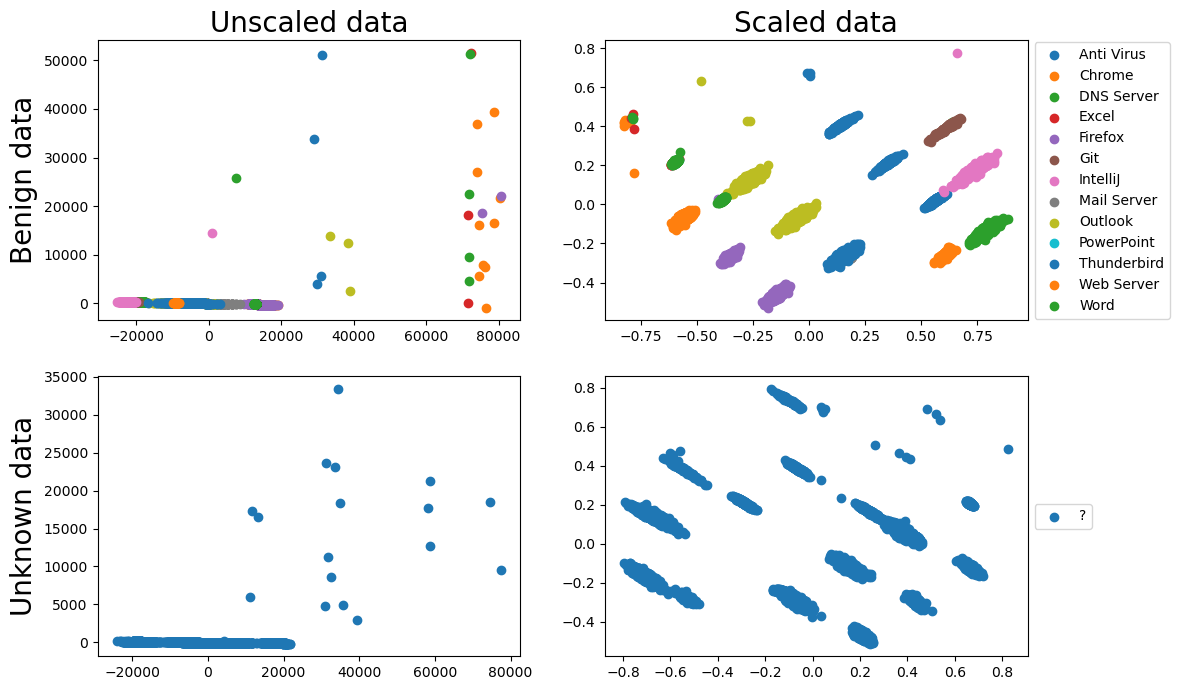

In [174]:
# Plots unscaled and scaled features
assignment.plot_scaled()

## 3. Model/Parameter selection
Currently we have a scaled matrix where each row contains a data sample, and each column a feature. Now that we have prepared the features that we feed into our NIDS, we have to choose an anomaly detection algorithm to observe new behaviour. Given that we only have access to benign data and unknown data, we cannot train a classifier. Therefore, we need to train a novelty/outlier detection algorithm. We will use a One-Class SVM.

A One-Class SVM uses a kernel function K to define the geometric relationship between a feature vector X and the support vectors Y. For an RBF (Gaussian) kernel, this relationship is defined as:

$$K(X, Y) = e^{-\frac{||x - y||^2}{2\sigma^2}}$$

**NB:** We use $||x - y||^2$ to denote the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between $x$ and $y$.

Now we implement the RBF kernel function.

In [175]:
def K(X: np.ndarray, Y: np.ndarray, sigma: float=1) -> float:
    k = 0
    for i in range(X.size):
        k = k + np.exp(-(X[i]-Y[i])**2/2*sigma**2)
    return k

A support vector machine (SVM) uses its kernel function to compute a score between a feature vector $X$ and support vector $Y$. This score is as the likelihood that $X$ and $Y$ originate from the same underlying distribution. Because an SVM contains multiple support vectors $Y_i$, we can assign a score to feature vector $X$ based on the likelihood that it shares the same underlying distribution with any of our support vectors $Y_i \in Y$. We compute this overall score by simply adding the (weighted) scores for $X$ with each support vector $Y_i$, which is called the soft score:

$$\text{soft score} = \sum_{i=0}^N w_iK(X, Y_i) \leq \tau$$

We compare this soft score with a threshold $\tau$ to determine if a point falls within or outside of our model. The assignment automatically computes the soft score with all weights as 1 for all given points $X$, support vectors $Y$ and the implemented kernel $K$.

We show the influence of different kernel values on the decision function for random support vectors and datapoints. All datapoints that appear in the red area are considered to fall within the soft hypersphere. All datapoints outside the area are considered anomalous. We see that the sigma changes the shape of the hypershpere and the threshold changes the volume while preserving the shape.

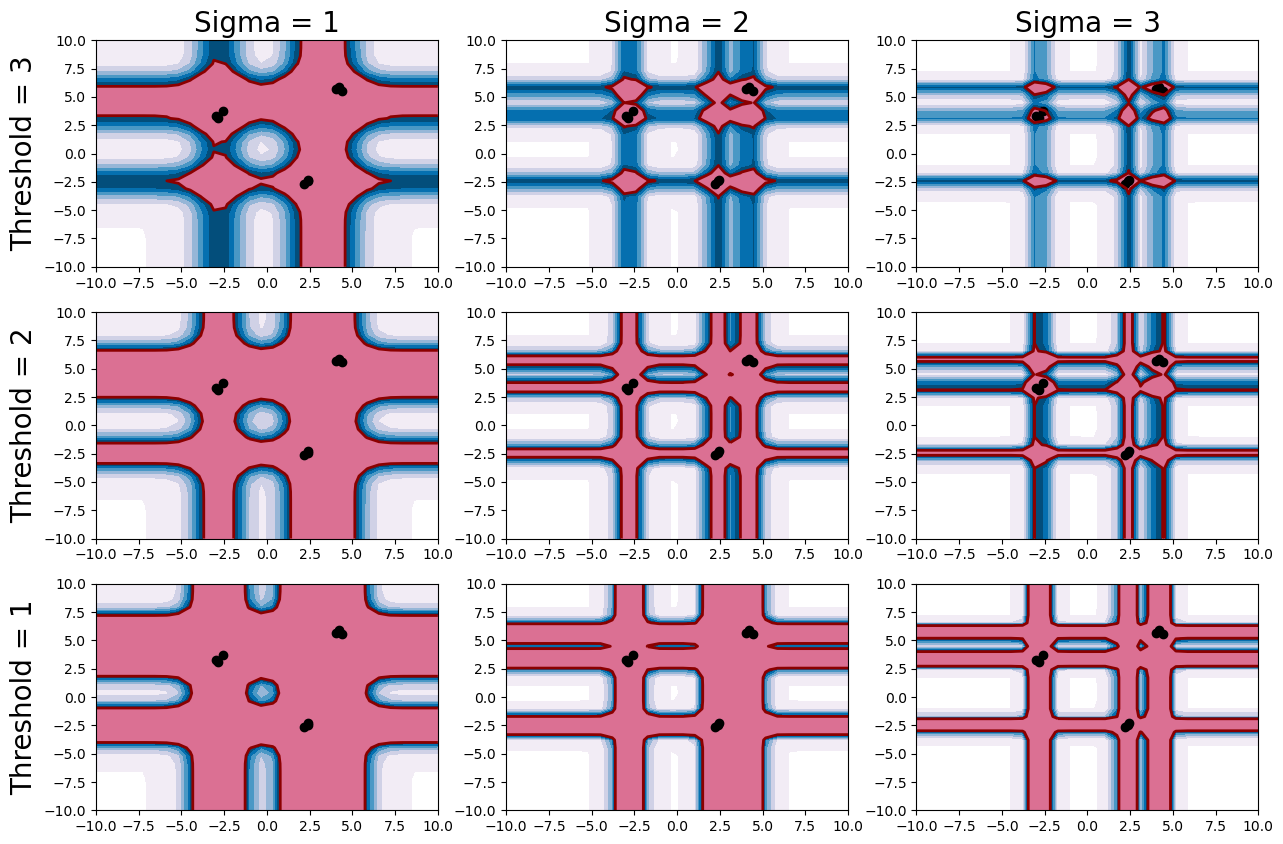

In [176]:
# Plots random kernels and shows the spheres produced by your kernel
assignment.plot_kernels(K, sigmas=[1, 2, 3], thresholds=[3, 2, 1])

Later we will use the `OneClassSVM` implementation from the `scikit-learn` library. This implementation automatically choses optimal values for the weights $w_i$ and threshold $\tau$. However, we can still set two values to influence this decision: `gamma` and `nu`. The `gamma` value determines the size of the kernel, similar to the value of $\sigma$. Additionally, the `nu` value sets an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors. We want to minimize the threshold $\tau$. The `nu` value allows us to adjust the number of support vectors as well as set the allowed number of errors the OneClassSVM can make during training while keeping the $\tau$ value minimal.

## 4. Evaluation

Now that we have taken a closer look at One-Class SVMs, we have to think about how we can train, test and evaluate the model. We do this to get an idea of how well the NIDS will perform in a real-world scenario, which allows us to optimise its parameters before deployment and classification of the unknown data. In order to evaluate our model, we require labelled data, i.e. data from the `benign.csv` file. Given that all data is benign, it might seem difficult to assess whether there are malicious network connections. However, we can think of ways to redefine our problem such that we can only use benign data in order to train and test the NIDS.

All data in the `benign.csv` file is labelled with the corresponding application that produced the data. We know that a malicious program is just another application that we have not seen in our benign data. We will leverage this observation to train and test our model.

To this end, we randomly select a couple of applications that we leave out of the training data and only use for the test dataset. These applications simulate the 'unknown' apps or malware that we might encounter in the `unknown.csv` dataset. All other applications will be present in both the train and test set. However, for these applications, we still need to select a portion of the data that we use in the test set, and a portion of the data that we use in the train set. We can define this portion with a `ratio`.

For example, if we have a dataset of 5 applications: $Apps = [\text{Firefox}, \text{Word}, \text{Git}, \text{Excel}, \text{Outlook}]$. Now we randomly select $[\text{Firefox}, \text{Excel}]$ to be our apps for the testing set, meaning $[\text{Word}, \text{Git}, \text{Outlook}]$ are the apps present in both the train and test datasets. Next we define our `ratio` for training items as `0.75`. This means that we select 75% of the flows from $[\text{Word}, \text{Git}, \text{Outlook}]$ as our train data and add the remaining 25% of flows to the test dataset.

Therefore, if we have the following input:

**Apps train:** $[\text{Word}, \text{Git}, \text{Outlook}]$ <br>
**Apps test:** $[\text{Firefox}, \text{Excel}]$ <br>
**Ratio:** 0.75 <br>

We will get the following split:

<div style="-webkit-column-count: 3; -moz-column-count: 3; column-count: 3; -webkit-column-rule: 1px dotted #e0e0e0; -moz-column-rule: 1px dotted #e0e0e0; column-rule: 1px dotted #e0e0e0; text-align: center;">
    <div style="display: inline-block;">
<h3 style="text-align: center;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Original data and Labels</h3>
        
|  Label  | feature 1 | feature 2 | ... | feature n |
|:-------:|:---------:|:---------:|:---:|:---------:|
| Firefox | value     | value     | ... | value     |
| Firefox | value     | value     | ... | value     |
| Word    | value     | value     | ... | value     |
| Word    | value     | value     | ... | value     |
| Word    | value     | value     | ... | value     |
| Git     | value     | value     | ... | value     |
| Git     | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
         
</div>
<div style="display: inline-block;">
<h3 style="text-align: center;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Train set</h3>
        
|  Label  | feature 1 | feature 2 | ... | feature n |
|:-------:|:---------:|:---------:|:---:|:---------:|
| Word    | value     | value     | ... | value     |
| Word    | value     | value     | ... | value     |
| Git     | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
        
</div>
<div style="display: inline-block;">
<h3 style="text-align: center;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Test set</h3>

|  Label  | feature 1 | feature 2 | ... | feature n |
|:-------:|:---------:|:---------:|:---:|:---------:|
| Firefox | value     | value     | ... | value     |
| Firefox | value     | value     | ... | value     |
| Word    | value     | value     | ... | value     |
| Git     | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
        
</div>
</div>

Now we implement the function `split()` that implements the split technique described above.

In [177]:
def split(
        data: np.ndarray,
        labels: np.ndarray,
        apps_train: List[str],
        apps_test: List[str],
        ratio: float,
    ) -> Tuple[list, list, list, list]:
    
    trainTestData = np.empty((0, data.shape[1]))
    test_data = np.empty((0, data.shape[1]))
    train_data = np.empty((0, data.shape[1]))
    trainTestLabels = np.empty(0)
    test_labels = np.empty(0)
    train_labels = np.empty(0)
    
    for flow in range(data.shape[0]):
        if labels[flow] in apps_train:
            trainTestData = np.vstack([trainTestData, data[flow]])
            trainTestLabels = np.append(trainTestLabels, labels[flow])
        if labels[flow] in apps_test:
            test_data = np.vstack([test_data, data[flow]])
            test_labels = np.append(test_labels, labels[flow])
    
    trainSize = round(ratio*(trainTestData.shape[0]))

    for i in range(trainSize):
        train_data = np.vstack([train_data, trainTestData[i]])
        train_labels = np.append(train_labels, trainTestLabels[i])

    for r in range(trainSize, trainTestData.shape[0]):
        test_data = np.vstack([test_data, trainTestData[r]])
        test_labels = np.append(test_labels, trainTestLabels[r])
        
    return train_data, train_labels, test_data, test_labels
        
# Sets split method
assignment.split = split

In [178]:
# Tests split method
assignment.test_split(verbose=True)

[[2.93332463e-05 1.86548529e-03 2.77777778e-01 ... 4.97797357e-01
  1.66305654e-01 0.00000000e+00]
 [3.10511746e-05 1.81756226e-03 2.63888889e-01 ... 5.31277533e-01
  1.64839530e-01 0.00000000e+00]
 [4.45451783e-06 3.75221690e-04 1.94444444e-01 ... 3.38325991e-01
  5.70936711e-02 0.00000000e+00]
 ...
 [4.41833091e-06 3.11176748e-04 1.52777778e-01 ... 6.97797357e-01
  1.83624824e-01 3.33333333e-01]
 [3.67699996e-06 3.05996189e-04 1.38888889e-01 ... 6.44933921e-01
  1.73645728e-01 3.33333333e-01]
 [3.81708459e-06 4.14181693e-04 2.08333333e-01 ... 6.73127753e-01
  2.18159117e-01 3.33333333e-01]]
Test case 1 - benign.csv:
apps_train = ['Anti Virus', 'Chrome', 'DNS Server', 'Excel', 'Firefox', 'Git', 'IntelliJ']
apps_test  = ['Mail Server', 'Outlook', 'PowerPoint', 'Thunderbird', 'Web Server', 'Word']
ratio      = 0.5

Test case 2 - benign.csv:
apps_train = ['Anti Virus', 'Outlook', 'DNS Server', 'Excel', 'Firefox', 'Git', 'IntelliJ', 'PowerPoint', 'Thunderbird', 'Web Server', 'Word']
apps_

The labels for this split are integers that are `+1` if the corresponding application is in the training data or `-1` if the corresponding application is not in the training data. We will use this to determine whether our NIDS can correctly determine whether apps are present in the training set (`+1`, benign) or whether they are not present in the training set (`-1`, malicious).

In [179]:
# Gets training and testing data
X_train, y_train, X_test, y_test = assignment.get_split(
    
        # Select the apps used for training, the rest will be used for testing
        apps_train = [
            'IntelliJ',
            'PowerPoint',
            'Thunderbird',
            'Web Server',
            'Chrome',
            'Word',
            'Mail Server',
            'Anti Virus',
            'Outlook',
            'DNS Server',
        ],
    
    
        # Select the ratio of flows from training apps used for training
        ratio     = 0.75,
)

# Prints overview of data
print(
"""
Your data is structured as follows:
-----------------------------------
Train data   (X_train): np.array of shape={}
Train labels (y_train): np.array of shape={}
Test  data   (X_test ): np.array of shape={}
Test  labels (y_test ): np.array of shape={}
""".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
)

[[2.93332463e-05 1.86548529e-03 2.77777778e-01 ... 4.97797357e-01
  1.66305654e-01 0.00000000e+00]
 [3.10511746e-05 1.81756226e-03 2.63888889e-01 ... 5.31277533e-01
  1.64839530e-01 0.00000000e+00]
 [4.45451783e-06 3.75221690e-04 1.94444444e-01 ... 3.38325991e-01
  5.70936711e-02 0.00000000e+00]
 ...
 [4.41833091e-06 3.11176748e-04 1.52777778e-01 ... 6.97797357e-01
  1.83624824e-01 3.33333333e-01]
 [3.67699996e-06 3.05996189e-04 1.38888889e-01 ... 6.44933921e-01
  1.73645728e-01 3.33333333e-01]
 [3.81708459e-06 4.14181693e-04 2.08333333e-01 ... 6.73127753e-01
  2.18159117e-01 3.33333333e-01]]

Your data is structured as follows:
-----------------------------------
Train data   (X_train): np.array of shape=(7198, 8)
Train labels (y_train): np.array of shape=(7198,)
Test  data   (X_test ): np.array of shape=(5391, 8)
Test  labels (y_test ): np.array of shape=(5391,)



Now that we have split our data into training and testing sets with the corresponding labels, we want to compute some metrics over a prediction. Most metrics are based on the True Positive (TP), False Positive (FP), True Negative (TN) and False Negative values (FN).

 * True Positives (TP), the amount of samples predicted as *unknown* (-1), that should be labelled as *unknown* (-1).
 * True Negatives (TN), the amount of samples predicted as *known* (+1), that should be labelled as *known* (+1).
 * False Positives (FP), the amount of samples predicted as *unknown* (-1), that should be labelled as *known* (+1).
 * False Negatives (FN), the amount of samples predicted as *known* (+1), that should be labelled as *unknown* (-1).

| $ $                | Actual Unknown      | Actual Known        |
|--------------------|---------------------|---------------------|
| Predicted Unknown  | True Positive (TP)  | False Positive (FP) |
| Predicted Known    | False Negative (FN) | True Negative (TN)  |


In [180]:
def TP(y_true: np.ndarray, y_pred: np.ndarray) -> int:
    count = 0
    for i in range(y_true.shape[0]):
        if y_true[i] == -1 and y_pred[i] == -1:
            count = count + 1
    return count
    
def TN(y_true: np.ndarray, y_pred: np.ndarray) -> int:
    c = 0
    for i in range(y_true.shape[0]):
        if y_true[i] == +1 and y_pred[i] == +1:
            c = c + 1
    return c
    
def FP(y_true: np.ndarray, y_pred: np.ndarray) -> int:
    count = 0
    for i in range(y_true.shape[0]):
        if y_true[i] == 1 and y_pred[i] == -1:
            count = count + 1
    return count
    
def FN(y_true: np.ndarray, y_pred: np.ndarray) -> int:
    count = 0
    for i in range(y_true.shape[0]):
        if y_true[i] == -1 and y_pred[i] == 1:
            count = count + 1
    return count
    
    
# Sets True/False Positive/Negative methods
assignment.TP = TP
assignment.TN = TN
assignment.FP = FP
assignment.FN = FN

In [181]:
assignment.test_metrics(verbose=True)

Test case 1:
y_pred: [-1 -1  1  1 -1  1  1 -1  1 -1]
y_true: [-1 -1 -1  1  1  1 -1  1 -1  1]
Test case 2:
y_pred: [-1  1 -1  1 -1  1 -1  1  1 -1]
y_true: [-1  1 -1  1 -1  1 -1  1 -1  1]
Test case 3:
y_pred: [-1  1 -1  1 -1  1 -1 -1 -1 -1]
y_true: [-1  1 -1  1 -1  1 -1  1  1 -1]
Test case 4:
y_pred: [-1  1 -1  1 -1  1 -1  1  1 -1]
y_true: [-1  1 -1  1 -1  1 -1 -1 -1 -1]
Test case 5:
y_pred: [-1 -1 -1  1  1  1  1  1  1  1]
y_true: [-1 -1 -1  1  1  1  1  1 -1 -1]
All test cases passed.


There are various metrics that are used widely in the evaluation of machine learning techniques. 5 of these from are:

The True Positive Rate (TPR), also called sensitivity, measures the proportion of actual positives that are correctly identified as such.
$$\text{TPR} = \frac{\text{TP}}{\text{TP}+\text{FN}} = 1-\text{FNR}$$

The True Negative Rate (TNR), also called specificity, measures the proportion of actual negatives that are correctly identified as such.
$$\text{TNR} = \frac{\text{TN}}{\text{TN}+\text{FP}} = 1-\text{FPR}$$

The False Positive Rate (FPR), measures the proportion of actual negatives that are identified as positives. If a NIDS has a high FPR, it will not find malicious software, making it useless.
$$\text{FPR} = \frac{\text{FP}}{\text{TN}+\text{FP}} = 1-\text{TNR}$$

The False Negative Rate (FNR), measures the proportion of actual positives that are identified as negatives. If a NIDS has a high FNR, it will raise alarms for benign network traffic, causing a lot of frustration for the people on the network.
$$\text{FNR} = \frac{\text{FN}}{\text{TP}+\text{FN}} = 1-\text{TPR}$$

The Accuracy (ACC) combines the TPR and FPR to get a complete overview of the system performance. An accuracy of 1.0 means everything is correctly classified. An accuracy of 0.0 means nothing is correctly classified.
$$\text{ACC} = \frac{\text{TP}+\text{TN}}{\text{TP}+\text{TN}+\text{FP}+\text{FN}}$$

The precision gives the ratio of 'how many selected items are relevant' and the recall gives the ratio of 'how many relevant items are selected'. The F1-score gives the harmonic mean between precision and recall and is often used in place of the accuracy.

$$\text{Precision} = \frac{\text{TP}}{\text{TP}+\text{FP}}$$

$$\text{Recall} = \text{TPR} = \frac{\text{TP}}{\text{TP}+\text{FN}}$$

$$\text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2 \text{TP}}{2 \text{TP} + \text{FP} + \text{FN}}$$


## 5. Classifier
Now that we have prepared the data and implemented some of the evaluation metrics, we are ready to create our Network Intrusion Detection System (NIDS). To this end, we will use the [OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) implementation from the scikit-learn library. This model uses the `fit()` method with train data of known classes to learn its model. Subsequently it will use the method `predict()` with test data as +1 if they fit the known model, or -1 if they are considered anomalous.

We import the One-class SVM from [Scikit-Learn - OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html). We initialize it with different parameters and run the subsequent code to fit and predict our training and testing data. We try to get the best performance by adjusting the `kernel`, `gamma` and `nu` values.

In [190]:
from sklearn.svm import OneClassSVM

assignment.NIDS = OneClassSVM(
    kernel = "rbf",
    gamma  = "scale",
    nu     = 0.03,
)

# fits the NIDS using the training data X_train
assignment.NIDS.fit(X_train)
# lets the NIDS predict the test data X_test
y_pred = assignment.NIDS.predict(X_test)

# We evaluate the prediction y_pred and compare it with the actual values y_test
assignment.prediction_report(y_test, y_pred)


Prediction report
-----------------
True  Positive Rate (TPR) = 0.333890
True  Negative Rate (TNR) = 0.943727
False Positive Rate (FPR) = 0.056273
False Negative Rate (FNR) = 0.666110
Accuracy            (ACC) = 0.605268

Precision                 = 0.880952
Recall                    = 0.333890
F1-score                  = 0.484246



As we observe from the results, our classifier's performance, particularly in terms of recall and F1-score, is not ideal, indicating it struggles to correctly identify many positive cases. To improve this, we could revisit our data preparation process and adjust the splitting parameters (`ratio` and `apps_train`) to ensure our training set is more representative of typical traffic patterns. Additionally, experimenting further with different hyperparameters for the One-Class SVM—such as adjusting the `kernel`, `gamma`, and `nu` values—might also help the model generalize better, reducing false negatives and boosting overall predictive accuracy.